In [2]:
import pandas as pd
import numpy as np
from sklearn import *
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
import requests
url = "https://raw.githubusercontent.com/abulbasar/machine-learning/master/Utils.py"
exec(requests.get(url).text)

In [5]:
df_train = pd.read_csv("/data/MNIST/mnist_train.csv")
df_test = pd.read_csv("/data/MNIST/mnist_test.csv")
X_train = df_train.iloc[:, 1:]
X_test = df_test.iloc[:, 1:]
y_train = df_train.iloc[:, 0]
y_test = df_test.iloc[:, 0]
scaler = preprocessing.StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

n_x 784 n_y 10
X Tensor("Placeholder:0", shape=(?, 784), dtype=float32)
y Tensor("Placeholder_1:0", shape=(?,), dtype=int32)
y_oh Tensor("one_hot:0", shape=(?, 10), dtype=float32)
fulllayer_1W <tf.Variable 'fulllayer_1W:0' shape=(784, 10) dtype=float32_ref>
fulllayer_1b <tf.Variable 'Variable:0' shape=(10,) dtype=float32_ref>
fulllayer_2W <tf.Variable 'fulllayer_2W:0' shape=(10, 10) dtype=float32_ref>
fulllayer_2b <tf.Variable 'Variable_1:0' shape=(10,) dtype=float32_ref>
Z Tensor("add:0", shape=(?, 10), dtype=float32)
y_pred Tensor("ArgMax:0", shape=(?,), dtype=int32)
matching Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy Tensor("Mean:0", shape=(), dtype=float32)
0 training [0.0703125] testing [0.08870887] logloss 3.4292
100 training [0.8515625] testing [0.8660866] logloss 1.01097
200 training [0.8984375] testing [0.89078909] logloss 0.329524
300 training [0.8515625] testing [0.90199018] logloss 1.04956
400 training [0.8828125] testing [0.90529054] logloss 0.302189
500 training [

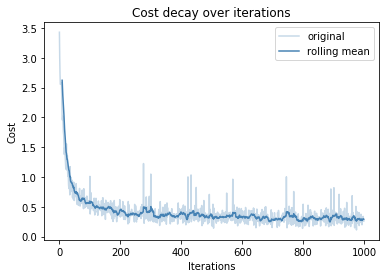

In [14]:
%%time 
tf.reset_default_graph()
tf.set_random_seed(1)

n_x = X_train_std.shape[1]
n_y = len(np.unique(y_train))
n_h = 400
learning_rate = 1e-3
max_iters = 1000

print("n_x", n_x, "n_y", n_y)

X = tf.placeholder(dtype=tf.float32, shape=[None, n_x])
y = tf.placeholder(dtype= tf.int32, shape=[None])

y_oh = tf.one_hot(y,  n_y)

print("X", X)
print("y", y)
print("y_oh", y_oh)

def full_layer(name, input, size, activation = None):
    input_size = int(input.get_shape()[1])
    #W = tf.Variable(tf.truncated_normal(shape=[input_size, size]))
    W = tf.get_variable(name + "W", shape = [input_size, size], 
                    initializer=tf.contrib.layers.xavier_initializer())
    b =  tf.Variable(tf.constant(0.0, shape=[size]))
    print(name + "W", W)
    print(name + "b", b)
    Z = tf.matmul(input, W) + b
    
    if callable(activation):
        Z = activation(Z)
        
    return Z

full_layer_1 = full_layer("fulllayer_1", X, n_y)
full_layer_2 = full_layer("fulllayer_2", full_layer_1, n_y)

Z = full_layer_1
print("Z", Z)

y_pred = tf.argmax(Z, 1, output_type=tf.int32)
print("y_pred", y_pred)

matching = tf.equal(y, y_pred)
print("matching", matching)

accuracy = tf.reduce_mean(tf.cast(matching, tf.float32))
print("accuracy", accuracy)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh,
                                                logits=Z))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost) 

scores = {}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    batchable = Batchable(X=X_train_std, y= y_train, batch_size=128)
    
    for i in range(max_iters): 
        X_batch, y_batch = batchable.next()
        
        _, cost_, accuracy_ = sess.run([optimizer, cost, accuracy], 
                    feed_dict={X: X_batch, y: y_batch})
        scores[i] = cost_
        if i % (max_iters//10) == 0 or i == max_iters - 1:
            training_accuracy_ = sess.run([accuracy], 
                    feed_dict={X: X_batch, y: y_batch})
            testing_accuracy_ = sess.run([accuracy], 
                    feed_dict={X: X_test_std, y: y_test})
            print(i, 
                  "training", training_accuracy_, 
                  "testing", testing_accuracy_,
                  "logloss", cost_)
    y_test_pred = sess.run(y_pred,
                        feed_dict={X: X_test_std, y: y_test})
    
    plot_scores(scores)

n_x 784 n_y 10
X Tensor("Placeholder:0", shape=(?, 784), dtype=float32)
y Tensor("Placeholder_1:0", shape=(?,), dtype=int32)
y_oh Tensor("one_hot:0", shape=(?, 10), dtype=float32)
fulllayer_1W <tf.Variable 'fulllayer_1W:0' shape=(784, 400) dtype=float32_ref>
fulllayer_1b <tf.Variable 'Variable:0' shape=(400,) dtype=float32_ref>
fulllayer_2W <tf.Variable 'fulllayer_2W:0' shape=(400, 400) dtype=float32_ref>
fulllayer_2b <tf.Variable 'Variable_1:0' shape=(400,) dtype=float32_ref>
fulllayer_3W <tf.Variable 'fulllayer_3W:0' shape=(400, 10) dtype=float32_ref>
fulllayer_3b <tf.Variable 'Variable_2:0' shape=(10,) dtype=float32_ref>
Z Tensor("add_2:0", shape=(?, 10), dtype=float32)
y_pred Tensor("ArgMax:0", shape=(?,), dtype=int32)
matching Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy Tensor("Mean:0", shape=(), dtype=float32)
0 training [0.5546875] testing [0.30833083] logloss 2.73422
100 training [0.96875] testing [0.93179315] logloss 0.484689
200 training [0.9765625] testing [0.95059508

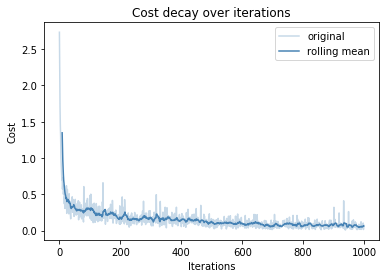

In [16]:
%%time 
tf.reset_default_graph()
tf.set_random_seed(1)

n_x = X_train_std.shape[1]
n_y = len(np.unique(y_train))
n_h = 400
learning_rate = 1e-3
max_iters = 1000

print("n_x", n_x, "n_y", n_y)

X = tf.placeholder(dtype=tf.float32, shape=[None, n_x])
y = tf.placeholder(dtype= tf.int32, shape=[None])

y_oh = tf.one_hot(y,  n_y)

print("X", X)
print("y", y)
print("y_oh", y_oh)

def full_layer(name, input, size, activation = None):
    input_size = int(input.get_shape()[1])
    #W = tf.Variable(tf.truncated_normal(shape=[input_size, size]))
    W = tf.get_variable(name + "W", shape = [input_size, size], 
                    initializer=tf.contrib.layers.xavier_initializer())
    b =  tf.Variable(tf.constant(0.0, shape=[size]))
    print(name + "W", W)
    print(name + "b", b)
    Z = tf.matmul(input, W) + b
    
    if callable(activation):
        Z = activation(Z)
        
    return Z

full_layer_1 = full_layer("fulllayer_1", X, n_h, tf.nn.relu)
full_layer_2 = full_layer("fulllayer_2", full_layer_1, n_h, tf.nn.relu)
full_layer_3 = full_layer("fulllayer_3", full_layer_2, n_y)

Z = full_layer_3
print("Z", Z)

y_pred = tf.argmax(Z, 1, output_type=tf.int32)
print("y_pred", y_pred)

matching = tf.equal(y, y_pred)
print("matching", matching)

accuracy = tf.reduce_mean(tf.cast(matching, tf.float32))
print("accuracy", accuracy)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh,
                                                logits=Z))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost) 

scores = {}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    batchable = Batchable(X=X_train_std, y= y_train, batch_size=128)
    
    for i in range(max_iters): 
        X_batch, y_batch = batchable.next()
        
        _, cost_, accuracy_ = sess.run([optimizer, cost, accuracy], 
                    feed_dict={X: X_batch, y: y_batch})
        scores[i] = cost_
        if i % (max_iters//10) == 0 or i == max_iters - 1:
            training_accuracy_ = sess.run([accuracy], 
                    feed_dict={X: X_batch, y: y_batch})
            testing_accuracy_ = sess.run([accuracy], 
                    feed_dict={X: X_test_std, y: y_test})
            print(i, 
                  "training", training_accuracy_, 
                  "testing", testing_accuracy_,
                  "logloss", cost_)
    y_test_pred = sess.run(y_pred,
                        feed_dict={X: X_test_std, y: y_test})
    
    plot_scores(scores)